In [1]:
import os.path
import tensorflow as tf
import helper
import warnings
from distutils.version import LooseVersion
import project_tests as tests
from math import ceil
import sys
from tqdm import tqdm
import scipy.misc
import numpy as np
import matplotlib.pyplot as plt

/anaconda/envs/carnd-term1/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.12.0


/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:7: UserWarning: No GPU found. Please use a GPU to train your neural network.
  import sys


#### To check the image files

In [5]:
data_dir = './data'
image_file = os.path.join(data_dir, 'data_road/training/image_2/um_000000.png')
image_org = scipy.misc.imread(image_file)
print(np.shape(image_org))

d:\users\F65318A\AppData\Local\Continuum\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


(375, 1242, 3)


In [6]:
data_dir = './data'
image_file = os.path.join(data_dir, 'data_road/testing/image_2/um_000000.png')
image_org = scipy.misc.imread(image_file)
print(np.shape(image_org))

d:\users\F65318A\AppData\Local\Continuum\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


(375, 1242, 3)


In [7]:
#To check the shape of the output image
image_file = os.path.join('runs', 'um_000000.png')
image_org = scipy.misc.imread(image_file)
print(np.shape(image_org))

d:\users\F65318A\AppData\Local\Continuum\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


(160, 576, 3)


#### To check the label images

d:\users\F65318A\AppData\Local\Continuum\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
d:\users\F65318A\AppData\Local\Continuum\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  
d:\users\F65318A\AppData\Local\Continuum\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':
d:\users\F65318A\AppData\Local\Continuum\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated i

(160, 576, 3)
(160, 576, 2)


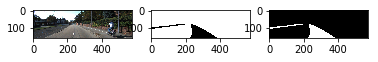

In [11]:
data_dir = './data'
image_shape = (160, 576)
background_color = np.array([255, 0, 0])

image_file = os.path.join(data_dir, 'data_road/training/image_2/um_000000.png')
gt_image_file = os.path.join(data_dir, 'data_road/training/gt_image_2/um_lane_000000.png')

image = scipy.misc.imresize(scipy.misc.imread(image_file), image_shape)
gt_image = scipy.misc.imresize(scipy.misc.imread(gt_image_file), image_shape)

gt_bg = np.all(gt_image == background_color, axis=2)
gt_bg = gt_bg.reshape(*gt_bg.shape, 1)
gt_image = np.concatenate((gt_bg, np.invert(gt_bg)), axis=2)

print(np.shape(image))
print(np.shape(gt_image))

fig = plt.figure()
plt.subplot(131)
plt.imshow(image)
    
plt.subplot(132)
plt.imshow(gt_image[:,:,0],cmap='gray')

plt.subplot(133)
plt.imshow(gt_image[:,:,1],cmap='gray')

#### Here starts the actual functions

In [6]:
def load_vgg(sess, vgg_path):
    """
    Load Pretrained VGG Model into TensorFlow.
    :param sess: TensorFlow Session
    :param vgg_path: Path to vgg folder, containing "variables/" and "saved_model.pb"
    :return: Tuple of Tensors from VGG model (image_input, keep_prob, layer3_out, layer4_out, layer7_out)
    """
    # TODO: Implement function
    #   Use tf.saved_model.loader.load to load the model and weights
    vgg_tag = 'vgg16'
    tf.saved_model.loader.load(sess,[vgg_tag],vgg_path)
    
    vgg_input_tensor_name = 'image_input:0'
    vgg_keep_prob_tensor_name = 'keep_prob:0'
    vgg_layer3_out_tensor_name = 'layer3_out:0'
    vgg_layer4_out_tensor_name = 'layer4_out:0'
    vgg_layer7_out_tensor_name = 'layer7_out:0'
    
    graph = tf.get_default_graph()
    #graph = tf.Graph()
    
    input_image = graph.get_tensor_by_name(vgg_input_tensor_name)
    keep_prob = graph.get_tensor_by_name(vgg_keep_prob_tensor_name)
    vgg_layer3_out = graph.get_tensor_by_name(vgg_layer3_out_tensor_name)
    vgg_layer4_out = graph.get_tensor_by_name(vgg_layer4_out_tensor_name)
    vgg_layer7_out = graph.get_tensor_by_name(vgg_layer7_out_tensor_name)
    
    return input_image, keep_prob, vgg_layer3_out, vgg_layer4_out, vgg_layer7_out
tests.test_load_vgg(load_vgg, tf) # This needs the 'variables' folder and saved_model.pb here

Tests Passed


In [7]:
def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes):
    """
    Create the layers for a fully convolutional network.  Build skip-layers using the vgg layers.
    :param vgg_layer3_out: TF Tensor for VGG Layer 3 output
    :param vgg_layer4_out: TF Tensor for VGG Layer 4 output
    :param vgg_layer7_out: TF Tensor for VGG Layer 7 output
    :param num_classes: Number of classes to classify
    :return: The Tensor for the last layer of output
    """
    # TODO: Implement function
    
    # Regularizers and initializers
    initializer = lambda: tf.truncated_normal_initializer(stddev=0.01)
    regularizer = lambda: tf.contrib.layers.l2_regularizer(1e-5)
    
    # 1x1 convolution
    layer7_out = tf.layers.conv2d(
    inputs=vgg_layer7_out,
    filters=num_classes,
    kernel_size=1,
    padding='same',
    kernel_regularizer=regularizer(),
    kernel_initializer=initializer(),
    name = 'layer7_out')
    
    
    # Upsample
    layer7_up = tf.layers.conv2d_transpose(
    inputs=layer7_out,
    filters=num_classes,
    kernel_size=4,
    strides=(2, 2),
    padding='same',
    kernel_regularizer=regularizer(),
    kernel_initializer=initializer(),
    name = 'layer7_up')
    
    # Scaling of pooling layer 4
    vgg_layer4_out_scaled = tf.multiply(vgg_layer4_out, 0.0001, name='vgg_layer4_out_scaled')
    # 1x1 convolution
    layer4_out = tf.layers.conv2d(
    inputs=vgg_layer4_out_scaled,
    filters=num_classes,
    kernel_size=1,
    padding='same',
    kernel_regularizer=regularizer(),
    kernel_initializer=initializer(),
    name = 'layer4_out')

    # Skip layer
    skip_1 = tf.add(layer7_up, layer4_out)

    # Upsample
    skip_1_up = tf.layers.conv2d_transpose(
    inputs=skip_1,
    filters=num_classes,
    kernel_size=4,
    strides=(2, 2),
    padding='same',
    kernel_regularizer=regularizer(),
    kernel_initializer=initializer(),
    name = 'skip_1_up')
    
    # Scaling of pooling layer 3
    vgg_layer3_out_scaled = tf.multiply(vgg_layer3_out, 0.0001, name='vgg_layer3_out_scaled')
    # 1x1 convolution
    layer3_out = tf.layers.conv2d(
    inputs=vgg_layer3_out_scaled,
    filters=num_classes,
    kernel_size=1,
    padding='same',
    kernel_regularizer=regularizer(),
    kernel_initializer=initializer(),
    name='layer3_out')

    # Skip layer
    skip_2 = tf.add(skip_1_up, layer3_out)

    # Upsampled final
    nn_last_layer = tf.layers.conv2d_transpose(
    inputs=skip_2,
    filters=num_classes,
    kernel_size=16,
    strides=(8, 8),
    padding='same',
    kernel_regularizer=regularizer(),
    kernel_initializer=initializer(),
    name='nn_last_layer')
    
    return nn_last_layer
tests.test_layers(layers)

Tests Passed


In [8]:
def optimize(nn_last_layer, correct_label, learning_rate, num_classes):
    """
    Build the TensorFLow loss and optimizer operations.
    :param nn_last_layer: TF Tensor of the last layer in the neural network
    :param correct_label: TF Placeholder for the correct label image
    :param learning_rate: TF Placeholder for the learning rate
    :param num_classes: Number of classes to classify
    :return: Tuple of (logits, train_op, cross_entropy_loss)
    """
    # TODO: Implement function
    
    logits = tf.reshape(nn_last_layer, (-1, num_classes), name='logits')
    truth = tf.reshape(correct_label, (-1, num_classes))
    predicts = tf.nn.softmax(logits, name='predicts')
    #global_step = tf.Variable(0, name='global_step', trainable=False)
    
    # Cross-entropy operation
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=truth)
    cross_entropy_loss = tf.reduce_mean(cross_entropy)
    tf.summary.scalar('cross_entropy_loss', cross_entropy_loss)
    
    # Regularization loss
    l2_loss = tf.losses.get_regularization_loss()
    tf.summary.scalar('l2_loss', l2_loss)
    
    total_loss = cross_entropy_loss + l2_loss
    tf.summary.scalar('total_loss', total_loss)
    
    #train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(total_loss, global_step)
    train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(total_loss)
    
    # Merge summary operation
    merged = tf.summary.merge_all()
    
    return logits, train_op, cross_entropy_loss
tests.test_optimize(optimize)
print("OK")

Tests Passed
OK


In [9]:
def train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, input_image,
             correct_label, keep_prob, learning_rate,saver):
    """
    Train neural network and print out the loss during training.
    :param sess: TF Session
    :param epochs: Number of epochs
    :param batch_size: Batch size
    :param get_batches_fn: Function to get batches of training data.  Call using get_batches_fn(batch_size)
    :param train_op: TF Operation to train the neural network
    :param cross_entropy_loss: TF Tensor for the amount of loss
    :param input_image: TF Placeholder for input images
    :param correct_label: TF Placeholder for label images
    :param keep_prob: TF Placeholder for dropout keep probability
    :param learning_rate: TF Placeholder for learning rate
    """
    # TODO: Implement function
    min_epochs = 20
    best_loss = 1e9
    failure = 0
    patience = 4
    
    sess.run(tf.global_variables_initializer())
    
    for e in range(epochs):
        epoch_loss = 0
        num_images = 0
        sys.stdout.flush()
        for images, labels in get_batches_fn(batch_size):
            _, loss = sess.run([
              train_op,
              cross_entropy_loss], feed_dict={
                  input_image: images,
                  correct_label: labels,
                  keep_prob: 0.5,
                  learning_rate: 1e-4})
            #writer.add_summary(summary, step)
            epoch_loss += loss * len(images)
            num_images += len(images)
            
        epoch_loss /= num_images
        sys.stderr.flush()
        print('Epoch {} loss: {:.3f}'.format(e + 1, epoch_loss))
        if e >= min_epochs and epoch_loss > best_loss:
          if failure == patience:
            break
          failure += 1
        else:
            failure = 0
            best_loss = epoch_loss
            print('Saving model')
            saver.save(sess, './model.ckpt')
    #pass
#tests.test_train_nn(train_nn) #This one can be called if 'saver' is removed in train_nn call
print("OK")

OK


In [11]:
def run():
    num_classes = 2
    image_shape = (160, 576)
    data_dir = './data'
    runs_dir = './runs'
    tests.test_for_kitti_dataset(data_dir) # This will also download the kitti dataset, if not already there
    
    correct_label = tf.placeholder(tf.int32, [None, None, None, num_classes])
    learning_rate = tf.placeholder(tf.float32)
    #keep_prob = tf.placeholder(tf.float32)
    
    epochs = 40
    batch_size = 4

    # Download pretrained vgg model
    helper.maybe_download_pretrained_vgg(data_dir)

    # OPTIONAL: Train and Inference on the cityscapes dataset instead of the Kitti dataset.
    # You'll need a GPU with at least 10 teraFLOPS to train on.
    #  https://www.cityscapes-dataset.com/
    
    #saver = tf.train.Saver()
    #new_graph = tf.Graph()
    #print("just before starting training")
    #input()

    with tf.Session() as sess:
        # Path to vgg model
        vgg_path = os.path.join(data_dir, 'vgg')
        # Create function to get batches
        get_batches_fn = helper.gen_batch_function(os.path.join(data_dir, 'data_road/training'), image_shape,augment=False)

        # OPTIONAL: Augment Images for better results
        #  https://datascience.stackexchange.com/questions/5224/how-to-prepare-augment-images-for-neural-network

        # TODO: Build NN using load_vgg, layers, and optimize function
        input_image, keep_prob, vgg_layer3_out, vgg_layer4_out, vgg_layer7_out = load_vgg(sess, vgg_path)
        
        nn_last_layer = layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes)
        
        logits, train_op, cross_entropy_loss = optimize(nn_last_layer, correct_label, learning_rate, num_classes)
        
        saver = tf.train.Saver()

        # TODO: Train NN using the train_nn function
        train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, input_image,
             correct_label, keep_prob, learning_rate,saver)

        # TODO: Save inference data using helper.save_inference_samples
        helper.save_inference_samples(runs_dir, data_dir, sess, image_shape, logits, keep_prob, input_image)

        # OPTIONAL: Apply the trained model to a video


#### Training

In [12]:
if __name__ == '__main__':
    run()
print("End")

Tests Passed


KeyboardInterrupt: 

#### Check output on a single image(Can run independently from here)

In [2]:
import numpy as np
import tensorflow as tf
import sys

# Third-party imports
import matplotlib.colors as colors
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
#from sklearn.metrices import precision_recall_fscore_support
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import scipy.misc

import imageio
import cv2

from tqdm import tqdm

In [3]:
# Matplotlib configuration
%matplotlib inline

INFO:tensorflow:Restoring parameters from ./model.ckpt
Model loaded


/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app
/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:32: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:35: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly inste

(160, 576, 3)


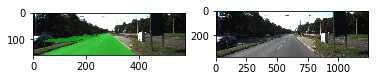

In [4]:
PIXEL_MAX = 255
data_dir = './data'
image_shape = (160, 576)
loaded_graph = tf.Graph()
load_dir = './model.ckpt'

with tf.Session(graph=loaded_graph) as sess:
    #Load saved model
    loader = tf.train.import_meta_graph(load_dir + '.meta')
    loader.restore(sess, load_dir)
    print("Model loaded")
    
    
    image_file = os.path.join(data_dir, 'data_road/testing/image_2/um_000000.png')
    image_org = scipy.misc.imread(image_file)
    image_resized = scipy.misc.imresize(image_org, image_shape) #This step is not required if image shape is already image_shape
    image_resized = image_resized.reshape(1,*image_resized.shape)#Adds a dimension at the beginning
    
    
    # Gather required tensor references
    input_image = loaded_graph.get_tensor_by_name('image_input:0')
    keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
    predicted = loaded_graph.get_tensor_by_name('predicts:0')
    
    im_softmax = sess.run([predicted], feed_dict={input_image: image_resized,keep_prob: 1.0})
    
    #predicted = predicted[0]
    #im_softmax = sess.run([predicts],feed_dict={image_pl: image,keep_prob: 1.0})
    
    im_softmax = im_softmax[0][:, 1].reshape(image_shape[0], image_shape[1])
    segmentation = (im_softmax > 0.5).reshape(image_shape[0], image_shape[1], 1)
    mask = np.dot(segmentation, np.array([[0, 255, 0, 127]]))
    mask = scipy.misc.toimage(mask, mode="RGBA")
    #print(np.shape(mask))
    #print(np.shape(image[0]))
    street_im = scipy.misc.toimage(image_resized[0])
    street_im.paste(mask, box=None, mask=mask)
    
    op_image = np.array(street_im)
    print(np.shape(op_image))
    
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(op_image)
    
    plt.subplot(122)
    plt.imshow(image_org)
    

#### Below is another way to apply semantic segmentation on a single image(Almost same as the last one). Testing images are on testing folder and there is no ground truth for these images¶

In [ ]:
PIXEL_MAX = 255
loaded_graph = tf.Graph()
load_dir = './model.ckpt'

image_shape = (160, 576)

feature_image_path = './data/data_road/testing/image_2/um_000003.png'

feature_image = imageio.imread(feature_image_path)
feature_copy = np.copy(feature_image)
#scipy is used in helper.gen_batch_function() for reading and resizing images.
feature_image = scipy.misc.imresize(feature_image, image_shape)
feature_image = feature_image.reshape(1,*feature_image.shape)

with tf.Session(graph=loaded_graph) as sess:
    #Load saved model
    loader = tf.train.import_meta_graph(load_dir + '.meta')
    loader.restore(sess, load_dir)
    
    # Gather required tensor references
    input_image = loaded_graph.get_tensor_by_name('image_input:0')
    keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
    predicted = loaded_graph.get_tensor_by_name('predicts:0')
    
    predicted = sess.run([predicted], feed_dict={input_image: feature_image,keep_prob: 1.0})
    #print(np.shape(predicted))
    predicted = predicted[0]
    
    binary_road_result = (predicted[:, 0] > .5).reshape(image_shape)
    binary_road_result = binary_road_result.astype('uint8')
    
binary_road_result = scipy.misc.imresize(binary_road_result, (375,1242))


fig = plt.figure(figsize=(16,21))
plt.subplot(211)
plt.imshow(feature_copy)

plt.subplot(212)
plt.imshow(binary_road_result, cmap='gray')
    
print("Done")

#### Load the graph to save as .pb file( saves the model as base_graph.pb)

In [3]:
loaded_graph = tf.Graph()
load_dir = './model.ckpt'

with tf.Session(graph=loaded_graph) as sess:
    #Load saved model
    loader = tf.train.import_meta_graph(load_dir + '.meta')
    loader.restore(sess, load_dir)
    print("Model loaded")
    
    #tf.get_default_graph().as_graph_def()
    graph_def = loaded_graph.as_graph_def() #current Graph as protobuffs
    
    # Parameters: 1) graph, 2) directory where we want to save the pb file,
    #             3) name of the file, 4) text format (True) or binary format.
    tf.train.write_graph(graph_def,".","base_graph.pb",False)
    

print("Model saved")

INFO:tensorflow:Restoring parameters from ./model.ckpt
Model loaded
Done


#### Follow this link for details about freezing the graph etc
https://stackoverflow.com/questions/45382917/how-to-optimize-for-inference-a-simple-saved-tensorflow-1-0-1-graph

#### Use this command in command window to freeze the graph

#####  python -m tensorflow.python.tools.freeze_graph --input_graph base_graph.pb --input_checkpoint model.ckpt --input_binary true --output_graph graph_frozen.pb --output_node_names=predicts

#### Check the number of operations

In [3]:
from graph_utils import load_graph
sess, base_ops = load_graph('base_graph.pb')
print(len(base_ops)) # 2165

#freeze graph by executing ./freeze_graph.sh
sess, frozen_ops = load_graph('graph_frozen.pb') #Assuming that frozen_graph is created
print(len(frozen_ops)) # 245

1764
249


#### Use this command in command window to optimize for performance

##### python -m tensorflow.python.tools.optimize_for_inference --input graph_frozen.pb --output graph_optimized.pb --frozen_graph True --input_names=image_input --output_names=predicts

In [4]:
from graph_utils import load_graph

sess, optimized_ops = load_graph('graph_optimized.pb')
print(len(optimized_ops)) # 200


204


#### python -m tensorflow.tools.graph_transforms.transform_graph.py --in_graph graph_frozen.pb out_graph=eightbit_graph.pb --inputs=image_input --outputs=predicts --transforms='
add_default_attributes
remove_nodes(op=Identity, op=CheckNumerics)
fold_constants(ignore_errors=true)
fold_batch_norms
fold_old_batch_norms
fuse_resize_and_conv
quantize_weights
quantize_nodes
strip_unused_nodes
sort_by_execution_order'

This is still not working

In [ ]:
from graph_utils import load_graph

sess, eightbit_ops = load_graph('eightbit_graph.pb')
print(len(eightbit_ops)) # 425


#### Reusing the graph for inference - approach 1

In [10]:
#This approach is not working
import sys
import time
from scipy.misc import imread, imresize
from glob import glob

def load_graphh(graph_file, use_xla=False):
    config = tf.ConfigProto()
    if use_xla:
        jit_level = tf.OptimizerOptions.ON_1
        config.graph_options.optimizer_options.global_jit_level = jit_level

    with tf.Session(graph=tf.Graph(), config=config) as sess:
        gd = tf.GraphDef()
        with tf.gfile.Open(graph_file, 'rb') as f:
            data = f.read()
            gd.ParseFromString(data)
        tf.import_graph_def(gd, name='')
        ops = sess.graph.get_operations()
        n_ops = len(ops)
        print("Inside load_graphh")
        print(sess._closed)
        return sess, ops

In [11]:
#from graph_utils import load_graph

data_dir = './data'
image_shape = (160, 576)

image_file = os.path.join(data_dir, 'data_road/testing/image_2/um_000000.png')
image_org = scipy.misc.imread(image_file)
image_resized = scipy.misc.imresize(image_org, image_shape) #This step is not required if image shape is already image_shape
image_resized = image_resized.reshape(1,*image_resized.shape)#Adds a dimension at the beginning

sess, _ = load_graphh('graph_frozen.pb')
print(sess._closed) #status of the session
#graph = sess1.graph
#print(sess1._closed)

#input_image = graph.get_tensor_by_name('image_input:0')
#keep_prob = graph.get_tensor_by_name('keep_prob:0')
#predicted = graph.get_tensor_by_name('predicts:0')

#with tf.Session(graph=graph) as sess:
#print(sess._closed)
#im_softmax = sess.run([predicted], feed_dict={input_image: image_resized,keep_prob: 1.0})
#print(sess._closed)
'''
    im_softmax = im_softmax[0][:, 1].reshape(image_shape[0], image_shape[1])
    segmentation = (im_softmax > 0.5).reshape(image_shape[0], image_shape[1], 1)
    mask = np.dot(segmentation, np.array([[0, 255, 0, 127]]))
    mask = scipy.misc.toimage(mask, mode="RGBA")
    
    street_im = scipy.misc.toimage(image_resized[0])
    street_im.paste(mask, box=None, mask=mask)
    
    op_image = np.array(street_im)
    print(np.shape(op_image))
    
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(op_image)
    
    plt.subplot(122)
    plt.imshow(image_org)
'''
print("done")

d:\users\F65318A\AppData\Local\Continuum\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys
d:\users\F65318A\AppData\Local\Continuum\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


Inside load_graphh
False
True
done


#### Reusing the graph for inference - approach 2

In [3]:
# Above code does not work, trying different way
import time
from glob import glob
def inference_images(data_dir, sess, image_shape, predicted, keep_prob, image_pl):
    # Run NN on test images and save them to HD
    print('Saving output images to: {}'.format(output_dir))
    image_folder =os.path.join(data_dir, 'data_road/testing','image_2')
    
    for image_file in glob(os.path.join(image_folder, '*.png')):
        image_resized = scipy.misc.imresize(scipy.misc.imread(image_file), image_shape)
        image_resized = image_resized.reshape(1,*image_resized.shape)
        
        im_softmax = sess.run([predicted], feed_dict={image_pl: image_resized,keep_prob: 1.0})
        
        im_softmax = im_softmax[0][:, 1].reshape(image_shape[0], image_shape[1])
        segmentation = (im_softmax > 0.5).reshape(image_shape[0], image_shape[1], 1)
        mask = np.dot(segmentation, np.array([[0, 255, 0, 127]]))
        mask = scipy.misc.toimage(mask, mode="RGBA")
        #print(np.shape(mask))
        #print(np.shape(image[0]))
        street_im = scipy.misc.toimage(image_resized[0])
        street_im.paste(mask, box=None, mask=mask)
        
        yield os.path.basename(image_file), np.array(street_im)

In [4]:
#This can be made a single script with name 'inference.py', for example
image_shape = (160, 576)
data_dir = './data_test'
runs_dir = './runs_test'

graph = tf.Graph()

use_xla=False
config = tf.ConfigProto()
if use_xla:
    jit_level = tf.OptimizerOptions.ON_1
    config.graph_options.optimizer_options.global_jit_level = jit_level
    
with tf.Session(graph=graph, config=config) as sess:
    gd = tf.GraphDef()
    with tf.gfile.Open('graph_optimized.pb', 'rb') as f:
        data = f.read()
        gd.ParseFromString(data)
    tf.import_graph_def(gd, name='')
    #ops = sess.graph.get_operations()
    #n_ops = len(ops)
    print("model loaded")
    
    # Make folder for current run
    output_dir = os.path.join(runs_dir, str(time.time()))
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)
    
    input_image = graph.get_tensor_by_name('image_input:0')
    keep_prob = graph.get_tensor_by_name('keep_prob:0')
    predicted = graph.get_tensor_by_name('predicts:0')
    
    image_outputs = inference_images(data_dir, sess, image_shape, predicted, keep_prob, input_image)
    
    for name, image in image_outputs:
        scipy.misc.imsave(os.path.join(output_dir, name), image)
print("Done")

model loaded
Saving output images to: ./runs_test/1542288827.614991


/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.
/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.
/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be r

Done


#### To fing IOU

In [10]:
# Matplotlib configuration
%matplotlib inline

In [11]:
def mean_iou(ground_truth, prediction, num_classes):
    # TODO: Use `tf.metrics.mean_iou` to compute the mean IoU.
    #iou, iou_op = None
    iou, iou_op = tf.metrics.mean_iou(labels=ground_truth,predictions=prediction,num_classes=num_classes)
    return iou, iou_op

In [12]:
data_dir = './data'
image_shape = (160, 576)
num_classes = 2
background_color = np.array([255, 0, 0])
graph = tf.Graph()

config = tf.ConfigProto()

with tf.Session(graph=graph, config=config) as sess:
    #Load saved model
    gd = tf.GraphDef()
    with tf.gfile.Open('graph_optimized.pb', 'rb') as f:
        data = f.read()
        gd.ParseFromString(data)
    tf.import_graph_def(gd, name='')
    print("model loaded")
    
    # Gather required tensor references
    input_image = graph.get_tensor_by_name('image_input:0')
    keep_prob = graph.get_tensor_by_name('keep_prob:0')
    predicted = graph.get_tensor_by_name('predicts:0')
    
    
    image_file = os.path.join(data_dir, 'data_road/training/image_2/um_000000.png')
    gt_image_file = os.path.join(data_dir, 'data_road/training/gt_image_2/um_lane_000000.png')
    
    image_resized = scipy.misc.imresize(scipy.misc.imread(image_file), image_shape)
    image_resized = image_resized.reshape(1,*image_resized.shape)
    
    gt_image = scipy.misc.imresize(scipy.misc.imread(gt_image_file), image_shape)
    gt_image = gt_image.reshape(1,*gt_image.shape)
    #print(np.shape(gt_image))
    gt_bg = np.all(gt_image == background_color, axis=2)
    #print(np.shape(gt_bg))
    gt_bg = gt_bg.reshape(*gt_bg.shape, 1)
    #print(np.shape(gt_bg))
    gt_image = np.concatenate((gt_bg, np.invert(gt_bg)), axis=2)
    #print(np.shape(gt_image))
    
    im_softmax = sess.run([predicted], feed_dict={input_image: image_resized,keep_prob: 1.0})
    print(np.shape(im_softmax))
    #predicted = predicted[0]
    #im_softmax = sess.run([predicts],feed_dict={image_pl: image,keep_prob: 1.0})
    
    im_softmax = im_softmax[0][:, 1].reshape(image_shape[0], image_shape[1])
    segmentation = (im_softmax > 0.5).reshape(image_shape[0], image_shape[1], 1)
    print(np.shape(segmentation))
    #print(np.shape(segmentation))
    mask = np.dot(segmentation, np.array([[0, 255, 0, 127]]))
    mask = scipy.misc.toimage(mask, mode="RGBA")
    #print(np.shape(mask))
    #print(np.shape(image[0]))
    street_im = scipy.misc.toimage(image_resized[0])
    street_im.paste(mask, box=None, mask=mask)
    
    #What should be the dimensions of ground truth and prediction?
    #iou, iou_op = mean_iou(ground_truth,prediction,num_classes)
    iou, iou_op = mean_iou(gt_image,segmentation,num_classes)
    sess.run(iou_op)
    print("Mean IoU =", sess.run(iou))
    
    #op_image = np.array(street_im)
    #print(np.shape(op_image))
    
    #fig = plt.figure()
    #plt.subplot(121)
    #plt.imshow(op_image)
    
    #plt.subplot(122)
    #plt.imshow(scipy.misc.imread(image_file))
print("Done") 

model loaded


/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:27: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:27: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


(1, 92160, 2)
(160, 576, 1)


/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:50: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:53: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


AttributeError: 'numpy.ndarray' object has no attribute 'get_shape'

#### Video : Model loaded from checkpoint

In [12]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [13]:
PIXEL_MAX = 255
import scipy.misc
import numpy as np

def genn_output_image(sess, predicts, keep_prob, image_pl, input_image, image_shape):
    #print("entered here")
    image_copy = np.copy(input_image)
    
    image = scipy.misc.imresize(input_image, image_shape)
    image = image.reshape(1,*image.shape)#Adds a dimension at the beginning
    
    im_softmax = sess.run([predicts],feed_dict={image_pl: image,keep_prob: 1.0})
    
    #im_softmax = im_softmax[0][:, 1].reshape(image_shape[0], image_shape[1])
    segmentation = (im_softmax[0][:, 1] > 0.5).reshape(image_shape)
    segmentation = segmentation.astype('uint8')
    
    #segmentation = (im_softmax > 0.5).reshape(image_shape[0], image_shape[1], 1)
    
    
    #At the beginning, I thought video frames are of same size as original training images, but are not, 
    #Video frames are of size (600,800), whereas original training images were of size (375, 1242)
    #segmentation = scipy.misc.imresize(segmentation, (375,1242))
    #segmentation = scipy.misc.imresize(segmentation, (600,800))
    #The size of the resizing below really depends on the oroginal frame sizes in the video
    segmentation = scipy.misc.imresize(segmentation, (720,1280))
    
    #mask = np.dot(segmentation.reshape(*segmentation.shape,1), np.array([[0, 255, 0, 127]]))
    mask = np.dot(segmentation.reshape(*segmentation.shape,1), np.array([[PIXEL_MAX * .8, 0, 0]]))
    #mask = scipy.misc.toimage(mask, mode="RGBA")
    p = image_copy + mask
    #print(np.shape(mask))
    #print(np.shape(image[0]))
    #street_im = scipy.misc.toimage(image_copy[0])
    #street_im.paste(mask, box=None, mask=mask)
    
    p[p > PIXEL_MAX] = PIXEL_MAX
    p = p.astype(np.uint8)
    
    #return np.array(street_im)
    return p


class MyVideoProcessor(object):
    def __init__(self,sess,image_pl,keep_prob,predicted):
        self.sess = sess
        self.predicted=predicted
        self.keep_prob=keep_prob
        self.image_pl=image_pl
        self.image_shape = (160, 576)
        return
    def pipeline(self, rgb_frame):
        #print(np.shape(rgb_frame))
        op_frame = genn_output_image(self.sess, self.predicted, self.keep_prob, self.image_pl, rgb_frame, self.image_shape)
        return op_frame

In [14]:
loaded_graph = tf.Graph()
load_dir = './model.ckpt'

with tf.Session(graph=loaded_graph) as sess:
    #Load saved model
    loader = tf.train.import_meta_graph(load_dir + '.meta')
    loader.restore(sess, load_dir)
    print("Model loaded")
    
    # Gather required tensor references
    input_image = loaded_graph.get_tensor_by_name('image_input:0')
    keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
    predicted = loaded_graph.get_tensor_by_name('predicts:0')
    
    my_video_processor_object = MyVideoProcessor(sess,input_image,keep_prob,predicted)
    project_video_output = 'test_video_output.mp4'
    clip = VideoFileClip("test_video.mp4").subclip(0,4)
    #clip = VideoFileClip("project_video.mp4").subclip(0,4)
    

    white_clip = clip.fl_image(my_video_processor_object.pipeline) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(project_video_output, audio=False)
print("Done")

INFO:tensorflow:Restoring parameters from ./model.ckpt
Model loaded
[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 99%|█████████▉| 100/101 [02:44<00:01,  1.57s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 8min 6s, sys: 37.6 s, total: 8min 44s
Wall time: 2min 46s
Done


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_output))

#### Video:Approach 2, model loaded from optimized graph

In [15]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [16]:
import scipy.misc
import numpy as np
import time

def generate_output_image(sess, predicts, keep_prob, image_pl, input_image, image_shape):
    #print("entered here")
    image = scipy.misc.imresize(input_image, image_shape)
    image = image.reshape(1,*image.shape)#Adds a dimension at the beginning
    im_softmax = sess.run([predicts],feed_dict={image_pl: image,keep_prob: 1.0})
    
    im_softmax = im_softmax[0][:, 1].reshape(image_shape[0], image_shape[1])
    segmentation = (im_softmax > 0.5).reshape(image_shape[0], image_shape[1], 1)
    mask = np.dot(segmentation, np.array([[0, 255, 0, 127]]))
    mask = scipy.misc.toimage(mask, mode="RGBA")
    #print(np.shape(mask))
    #print(np.shape(image[0]))
    street_im = scipy.misc.toimage(image[0])
    street_im.paste(mask, box=None, mask=mask)
    
    return np.array(street_im)



class MyVideoProcessor1(object):
    def __init__(self,sess,image_pl,keep_prob,predicted):
        self.sess = sess
        self.predicted=predicted
        self.keep_prob=keep_prob
        self.image_pl=image_pl
        self.image_shape = (160, 576)
        return
    def pipeline(self, rgb_frame):
        op_frame = generate_output_image(self.sess, self.predicted, self.keep_prob, self.image_pl, rgb_frame, self.image_shape)
        return op_frame


In [17]:
graph = tf.Graph()

use_xla=False
config = tf.ConfigProto()
if use_xla:
    jit_level = tf.OptimizerOptions.ON_1
    config.graph_options.optimizer_options.global_jit_level = jit_level
    
with tf.Session(graph=graph, config=config) as sess:
    gd = tf.GraphDef()
    with tf.gfile.Open('graph_optimized.pb', 'rb') as f:
        data = f.read()
        gd.ParseFromString(data)
    tf.import_graph_def(gd, name='')
    #ops = sess.graph.get_operations()
    #n_ops = len(ops)
    print("model loaded")
    
    input_image = graph.get_tensor_by_name('image_input:0')
    keep_prob = graph.get_tensor_by_name('keep_prob:0')
    predicted = graph.get_tensor_by_name('predicts:0')
    
    my_video_processor_object = MyVideoProcessor1(sess,input_image,keep_prob,predicted)
    project_video_output = 'test_video_output1.mp4'
    clip = VideoFileClip("test_video.mp4")
    
    
    white_clip = clip.fl_image(my_video_processor_object.pipeline) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(project_video_output, audio=False)
print("Done")

model loaded
[MoviePy] >>>> Building video test_video_output1.mp4
[MoviePy] Writing video test_video_output1.mp4


100%|█████████▉| 1260/1261 [30:58<00:01,  1.48s/it]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output1.mp4 



CPU times: user 1h 47min 25s, sys: 6min 6s, total: 1h 53min 32s
Wall time: 30min 58s
Done


### To Do: What if we want to calculate IOU on all training images(test images have no ground truth, so no IOU calculation possible